# Domain Adaptation in Computer Vision

This notebook aims to prove if Domain Adaptation, specifically CORAL Loss, is effective at improving CNN accuracy.

Original Paper found [here](https://arxiv.org/pdf/1607.01719)

 This project uses the Office-31 dataset, shortened down from 35 classes to 7 classes to reduce operations

## Office-31 Dataset:
 This dataset is comprised of 35 classes of objects and images taken through 3 different cameras: Webcam, DSLR, Amazon. These cameras vary in focus, haze, saturation, creating randomized errors that reflect real world Convolutional Neural Networks (CNN) applications.

 This project uses DSLR for training and Webcam for validation, testing the ability of the EfficientNet V2 model to detect generalized, domain-invariant features which exist among all samples, through being exposed to an object, seen through the lens of a faulty camera, to a better quality camera.

 This investigation uses the first 10 classes of Office-31 for simplicity

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install torch efficientnet_pytorch
%pip install --quiet torch torchvision efficientnet_pytorch scipy
%pip install --upgrade torchvision

  Using cached efficientnet_pytorch-0.7.1.tar.gz (21 kB)
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjit

In [12]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from efficientnet_pytorch import EfficientNet
import numpy as np
import random
from scipy.spatial.distance import jensenshannon
from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt


In [13]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 10
TRIALS = 3
NUM_CLASSES = 10
FINE_TUNE_EPOCHS = 5

# Load datasets
root_dir = 'Office-31'

In [14]:
# Data Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dslr_dataset = datasets.ImageFolder(root=root_dir + 'dslr', transform=transform)
webcam_dataset = datasets.ImageFolder(root=root_dir + 'webcam', transform=transform)
amazon_dataset = datasets.ImageFolder(root=root_dir + 'amazon', transform=transform)

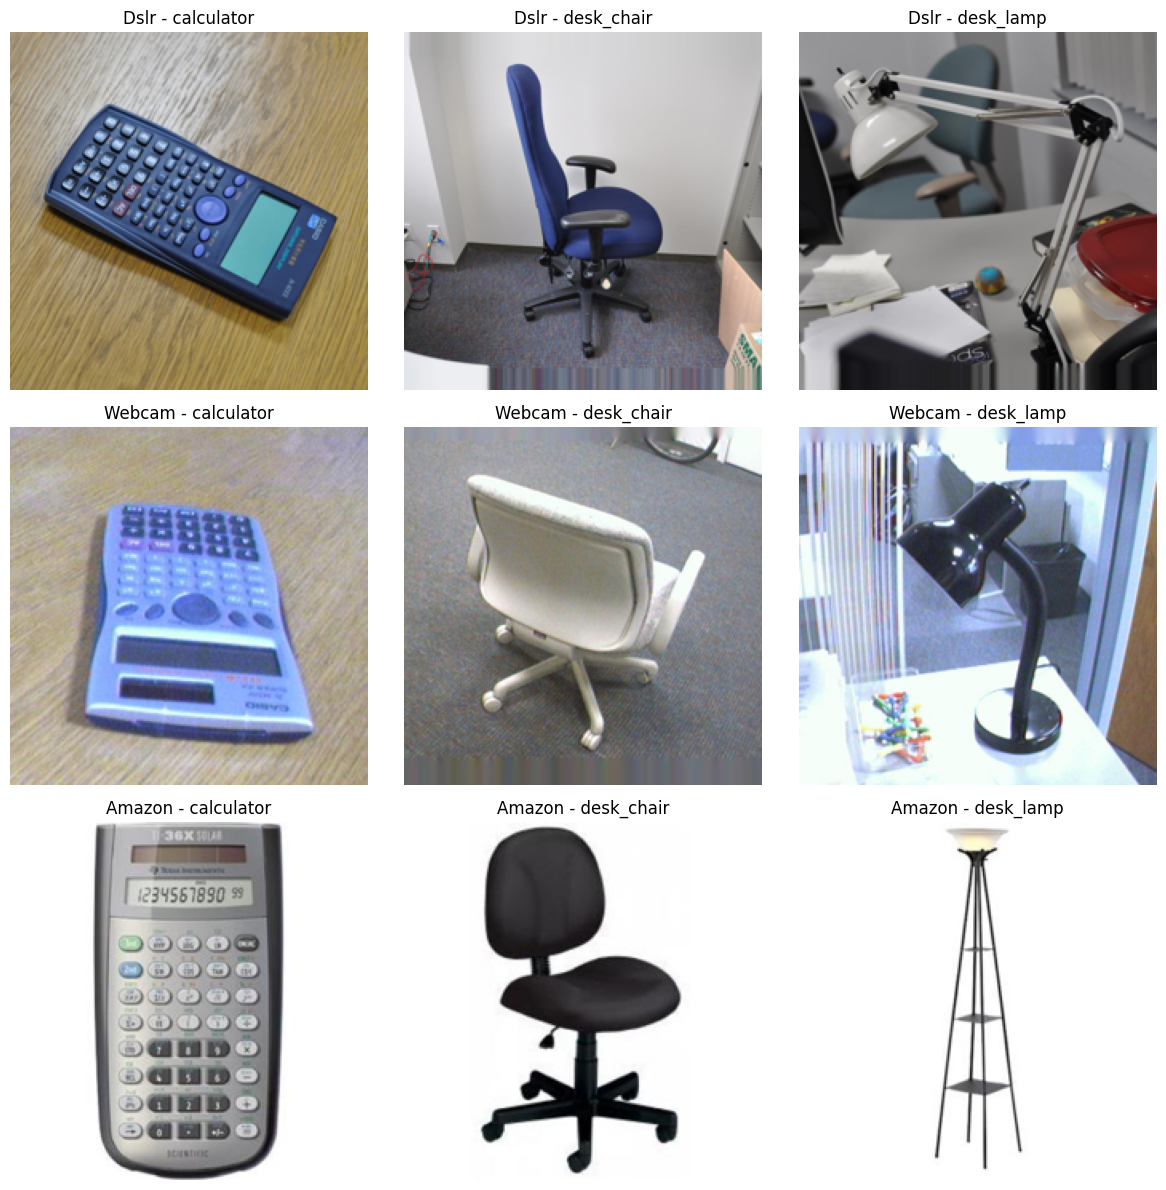

In [16]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Show images per folder from the Office-31 dataset (DSLR, Webcam, Amazon)
def show_sample_images_per_folder(root_dir):
    domains = ['dslr', 'webcam', 'amazon']

    fig, axs = plt.subplots(len(domains), 3, figsize=(12, 4 * len(domains)))

    for row, domain in enumerate(domains):
        domain_folder = os.path.join(root_dir, domain)

        # Get the subfolders (categories) for each domain
        subfolders = sorted(os.listdir(domain_folder))

        for col, subfolder in enumerate(subfolders[:3]):  # Show 3 random categories for simplicity
            folder_path = os.path.join(domain_folder, subfolder)

            # Get a random image from the category folder
            image_files = os.listdir(folder_path)
            random_image = random.choice(image_files)

            # Open the image using PIL
            img_path = os.path.join(folder_path, random_image)
            img = Image.open(img_path)
            img = img.resize((224, 224))  # Resize to match the model input size

            # Display the image
            axs[row, col].imshow(img)
            axs[row, col].set_title(f"{domain.capitalize()} - {subfolder}")
            axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()
show_sample_images_per_folder(root_dir)


As seen, the picture vary over each camera: Amazon, DSLR, Webcam, through color contrast, background environment, shadow and/or haze.

# Data Analysis on Distribution Shift

We will extract the Kolmogorov-Smirnov & Jensen Shannon Divergence scores between the source and target domains Webcam and DSLR

In [17]:


# Distribution shift testing

def compute_distribution_shift(dataset1, dataset2, name1="Source", name2="Target"):
    sample_loader1 = DataLoader(dataset1, batch_size=64, shuffle=False)
    sample_loader2 = DataLoader(dataset2, batch_size=64, shuffle=False)

    features1 = []
    features2 = []

    model = EfficientNet.from_pretrained('efficientnet-b0')
    model._fc = nn.Identity()
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for x, _ in sample_loader1:
            x = x.to(device)
            f = model(x).cpu().numpy()
            features1.append(f)
            if len(features1) > 3: break

        for x, _ in sample_loader2:
            x = x.to(device)
            f = model(x).cpu().numpy()
            features2.append(f)
            if len(features2) > 3: break

    features1 = np.concatenate(features1, axis=0)
    features2 = np.concatenate(features2, axis=0)

    jsd = jensenshannon(np.mean(features1, axis=0), np.mean(features2, axis=0))
    ks_stat, ks_p = ks_2samp(np.mean(features1, axis=1), np.mean(features2, axis=1))

    print(f"\nDistribution shift from {name1} to {name2}:")
    print(f"  Jensen-Shannon Divergence: {jsd:.4f}")
    print(f"  Kolmogorov-Smirnov Test: statistic={ks_stat:.4f}, p-value={ks_p:.4f}")

compute_distribution_shift(dslr_dataset, webcam_dataset, "DSLR", "Webcam")


Loaded pretrained weights for efficientnet-b0

Distribution shift from DSLR to Webcam:
  Jensen-Shannon Divergence: inf
  Kolmogorov-Smirnov Test: statistic=0.1129, p-value=0.5668


The scores show us that the distribution are somewhat identical, however they aren't similar in real world standards

# odel Architecture and Loss Function

## Data Loaders

We initialize separate `DataLoader` objects for the source and target domains. The source domain (DSLR) data is shuffled to improve generalization during training, while the target domain (Webcam) data remains in order for evaluation.

```python
dslr_loader = DataLoader(dslr_dataset, batch_size=BATCH_SIZE, shuffle=True)
webcam_loader = DataLoader(webcam_dataset, batch_size=BATCH_SIZE, shuffle=False)

The ```CoralLoss``` class implements the CORrelation ALignment (CORAL) loss function, which is used in domain adaptation to minimize the domain shift between source and target feature distributions. It does so by aligning their second-order statistics (i.e., covariance matrices).

CORAL (CORrelation ALignment) Loss is defined as the distance between the covariance matrices of the source and target feature embeddings. These embeddings are extracted from intermediate layers of the network. The objective is to minimize domain shift by reducing the discrepancy between the second-order statistics (i.e., covariances) of the source and target domains. In the context of the altered EfficientNet V2, CORAL loss encourages the network to learn features that are domain-invariant, hence aligning the distributions of the source and target embeddings on a multidimensional plane.

The formula is given for Coral:

$$
\mathcal{L}_{\text{CORAL}} = \frac{1}{4d^2} \left\| C_S - C_T \right\|_F^2
$$

where $ \left\|\right\|_F $ represent the Frobenius norm.

The Frobenius norm, represented by:

$$
\| A \|_F = \sqrt{ \sum_{i=1}^{m} \sum_{j=1}^{n} |a_{ij}|^2 }
$$

Calculates the distance between two covariance embeddings between the matrices

In order to calculate second-order statistics (covariances):

$$
C = \frac{1}{n - 1} X^\top X - \frac{1}{n(n - 1)} X^\top \mathbf{1} \mathbf{1}^\top X
$$

$$
\begin{aligned}
X &\in \mathbb{R}^{n \times d} \quad &\text{Feature matrix (}n\text{ samples, }d\text{ features)} \\
\mathbf{1} &\in \mathbb{R}^{n \times 1} \quad &\text{Vector of all ones} \\
X^\top &\in \mathbb{R}^{d \times n} \quad &\text{Transpose of }X \\
C &\in \mathbb{R}^{d \times d} \quad &\text{Covariance matrix} \\
n &\in \mathbb{N} \quad &\text{Number of samples in the batch}
\end{aligned}
$$

In [18]:

# DataLoaders
dslr_loader = DataLoader(dslr_dataset, batch_size=BATCH_SIZE, shuffle=True)
webcam_loader = DataLoader(webcam_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Deep CORAL Loss
class CoralLoss(nn.Module):
    def forward(self, source, target):
        d = source.size(1)
        source_c = self.covariance(source)
        target_c = self.covariance(target)
        loss = torch.mean(torch.mul((source_c - target_c), (source_c - target_c)))
        return loss / (4 * d * d)

    def covariance(self, x):
        x = x - x.mean(dim=0, keepdim=True)
        return x.T @ x / (x.size(0) - 1)

# Feature Extractor + Classifier
class DomainNet(nn.Module):
    def __init__(self, use_coral=False):
        super().__init__()
        self.use_coral = use_coral
        self.feature_extractor = EfficientNet.from_pretrained('efficientnet-b0')
        self.feature_extractor._fc = nn.Identity()
        self.classifier = nn.Linear(1280, NUM_CLASSES)

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits, features



# Training CORAL / No CORAL

This function handles the model training process, with an option to include the Deep CORAL loss for domain adaptation. It returns the trained model and a list of loss values per epoch.

The function initializes a DomainNet model with or without CORAL.

During each epoch, it trains on both the source domain (e.g., DSLR) and target domain (e.g., Webcam):

If CORAL is enabled:

Uses both classification loss on source labels and CORAL loss to align source/target features.

Otherwise:

Only classification loss is used on the source data.

After each epoch, the current loss is printed and stored


In [19]:

# Training Loop

def train_model(use_coral=False):
    loss_list=[]
    model = DomainNet(use_coral=use_coral).to(device)
    optimizer = optim.Adam(model.parameters())

    if use_coral:
        class_criterion = nn.CrossEntropyLoss()
        coral_criterion = CoralLoss()
    else:
        criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(EPOCHS):
        for (src_x, src_y), (tgt_x, _) in zip(dslr_loader, webcam_loader):
            src_x, src_y = src_x.to(device), src_y.to(device)
            tgt_x = tgt_x.to(device)

            optimizer.zero_grad()
            src_logits, src_feat = model(src_x)

            if use_coral:
                _, tgt_feat = model(tgt_x)
                loss_class = class_criterion(src_logits, src_y)
                loss_coral = coral_criterion(src_feat, tgt_feat)
                loss = loss_class + loss_coral
            else:
                loss = criterion(src_logits, src_y)

            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} | Loss {loss}")
        loss_list.append(loss)
    return model, loss_list


# Evaluation Metrics

This function evaluates the performance of a trained model on a target domain dataset (e.g., Webcam). It computes various metrics like accuracy, precision, recall, and F1-score. Additionally, it extracts the features, which are the covariance matrices, used for CORAL Loss, from the model's penultimate layer.

In [20]:

# Evaluation
def evaluate(model):
    model.eval()
    y_true, y_pred, feats = [], [], []

    with torch.no_grad():
        for x, y in webcam_loader:
            x = x.to(device)
            logits, features = model(x)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y.numpy())
            feats.append(features.cpu().numpy())

    feats = np.concatenate(feats, axis=0)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average='macro'),
        "recall": recall_score(y_true, y_pred, average='macro'),
        "f1": f1_score(y_true, y_pred, average='macro'),
        "features": feats
    }


# Trial Execution for Model Evaluation

In this section, we define the trial execution process for evaluating the performance of models with and without Deep CORAL. This approach runs multiple trials and computes the average performance metrics, such as accuracy, precision, recall, and F1-score. The results are used to compare the effectiveness of the models with and without the CORAL loss.

In [21]:
total_loss_list=[]

# Trial Execution
def run_trials(use_coral=False):
    metrics_all = []
    total_time = 0
    TRIALS=3
    for trial in range(TRIALS):
        print(f"Trial {trial+1}/{TRIALS} {'[With CORAL]' if use_coral else '[Baseline]'}")
        model, loss_list=train_model(use_coral=use_coral)
        eval_metrics = evaluate(model)
        metrics_all.append(eval_metrics)
        total_loss_list.append(loss_list)

    avg = {
        key: np.mean([m[key] for m in metrics_all]) for key in ['accuracy', 'precision', 'recall', 'f1']
    }
    return avg, model, metrics_all[-1]["features"]

# Run Experiments
print("Running Control (No CORAL)...")
ctrl_results, ctrl_model, ctrl_feats = run_trials(use_coral=False)

print("\nRunning Deep CORAL...")
coral_results, coral_model, coral_feats = run_trials(use_coral=True)


Running Control (No CORAL)...
Trial 1/3 [Baseline]
Loaded pretrained weights for efficientnet-b0
Epoch 1 | Loss 1.6260254383087158
Epoch 2 | Loss 0.9737294912338257
Epoch 3 | Loss 0.8986795544624329
Epoch 4 | Loss 0.11155245453119278
Epoch 5 | Loss 0.36964911222457886
Epoch 6 | Loss 0.9765341877937317
Epoch 7 | Loss 0.43934717774391174
Epoch 8 | Loss 0.30194684863090515
Epoch 9 | Loss 0.17917656898498535
Epoch 10 | Loss 0.19187739491462708
Trial 2/3 [Baseline]
Loaded pretrained weights for efficientnet-b0
Epoch 1 | Loss 1.8398244380950928
Epoch 2 | Loss 1.3623546361923218
Epoch 3 | Loss 0.654396653175354
Epoch 4 | Loss 0.3053005337715149
Epoch 5 | Loss 0.5666362047195435
Epoch 6 | Loss 0.06287890672683716
Epoch 7 | Loss 0.08228791505098343
Epoch 8 | Loss 0.05930238217115402
Epoch 9 | Loss 0.15529030561447144
Epoch 10 | Loss 0.2961316704750061
Trial 3/3 [Baseline]
Loaded pretrained weights for efficientnet-b0
Epoch 1 | Loss 1.8813457489013672
Epoch 2 | Loss 1.1537307500839233
Epoch 3 | 

In [22]:


# Results
print("\n=== Final Averaged Results ===")
print("Baseline (No CORAL):", ctrl_results)
print("With Deep CORAL:", coral_results)


=== Final Averaged Results ===
Baseline (No CORAL): {'accuracy': np.float64(0.9431524547803618), 'precision': np.float64(0.9424032489249882), 'recall': np.float64(0.9317822333611807), 'f1': np.float64(0.9269902776035442)}
With Deep CORAL: {'accuracy': np.float64(0.9793281653746769), 'precision': np.float64(0.9779696969696969), 'recall': np.float64(0.9764883984153934), 'f1': np.float64(0.975497023373915)}


In [23]:
def plot_tensor(tensor_list):
  raw_values = np.array([t.item() for t in tensor_list])
  return raw_values

In [24]:
#No CORAL Loss graph Trial 1,2,3

trial_1 = total_loss_list[0]
trial_2 = total_loss_list[1]
trial_3 = total_loss_list[2]

#CORAL Loss graph Trial 1,2,3

c_trial_1 = total_loss_list[3]
c_trial_2 = total_loss_list[4]
c_trial_3 = total_loss_list[5]

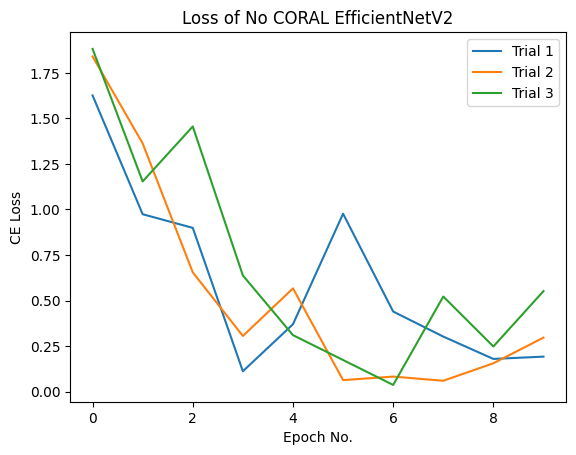

In [31]:
plt.plot(plot_tensor(trial_1), label="Trial 1")
plt.plot(plot_tensor(trial_2), label="Trial 2")
plt.plot(plot_tensor(trial_3), label="Trial 3")

plt.legend()

plt.ylabel("CE Loss")
plt.xlabel("Epoch No.")
plt.title("Loss of No CORAL EfficientNetV2")

plt.savefig("Result/Loss-of-No-CORAL-EfficientNetV2.png")

plt.show()

Without the use of CORAL, the loss of the model exhibits significant fluctuations

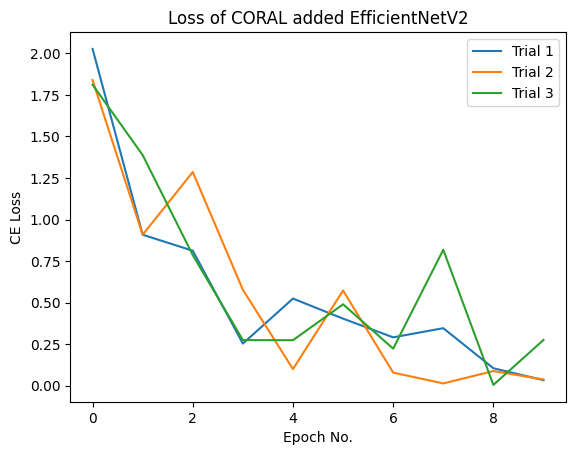

In [30]:
plt.plot(plot_tensor(c_trial_1), label="Trial 1")
plt.plot(plot_tensor(c_trial_2), label="Trial 2")
plt.plot(plot_tensor(c_trial_3), label="Trial 3")

plt.legend()

plt.ylabel("CE Loss")
plt.xlabel("Epoch No.")

plt.title("Loss of CORAL added EfficientNetV2")

plt.savefig("Result/Loss-of-CORAL-added-EfficientNetV2.png")

plt.show()

With the use of CORAL, the loss of the model exhibits significantly less fluctuations than the control model, showing Domain Adaptation's quality capabilities in smoother-than-normal training.

It is also seen that the CORAL Model has also achieved a lower average loss than the No-CORAL Model.

# Download Data & Model

In [27]:
import pandas as pd

# Create DataFrame with metrics
metrics_df = pd.DataFrame([
    {"Model": "Baseline", **ctrl_results},
    {"Model": "Deep CORAL", **coral_results}
])

print("\n=== Metrics DataFrame ===")
print(metrics_df)

metrics_df.to_csv("Result/Evaluation Base CORAL.csv")



=== Metrics DataFrame ===
        Model  accuracy  precision    recall        f1
0    Baseline  0.943152   0.942403  0.931782  0.926990
1  Deep CORAL  0.979328   0.977970  0.976488  0.975497


In [28]:
torch.save(ctrl_model,"Models/Control-EfficientNet-Model.pt")

In [29]:
torch.save(coral_model, "Models/EfficientNet-Model-with-CORAL.pt")